# Lab 4: Data Imputation using an Autoencoder


In this lab, you will build and train an autoencoder to impute (or "fill in") missing data.

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features.

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link:

https://colab.research.google.com/drive/1lJL0LngLnM6tVbWzPTdAuq6FGyeEEgkl?usp=sharing


In [ ]:
import csv
import numpy as np
import random
import torch
import torch.utils.data

## Part 0

We will be using a package called `pandas` for this assignment.

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here:
https://pandas.pydata.org/pandas-docs/stable/install.html

In [ ]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [ ]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

<ipython-input-3-037957db2593>:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(


In [ ]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset.

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`.

Like numpy arrays and torch tensors,
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [ ]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names,
for example `df["race"]`, `df["hr"]`, or even index multiple columns
like below.

In [ ]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [ ]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1`

would increment everyone's age by 1.

In [ ]:
##The describe() function gives us the required statistics for each of the columns
df.describe()

,age,fnlwgt,yredu,capgain,caploss,workhr
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [ ]:
#Normalizing each of the columns using min-max normalization
df['age'] = (df['age'] - 17)/(90 - 17)
df['fnlwgt'] = (df['fnlwgt'] - 12285)/(1484705 - 12285)
df['yredu'] = (df['yredu'] - 1)/(16 - 1)
df['capgain'] = (df['capgain'] - 0)/99999
df['caploss'] = (df['caploss'] - 0)/4356
df['workhr'] = (df['workhr']-1)/(99 - 1)

df

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,0.301370,State-gov,0.044302,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.021740,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,0.048238,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,0.138113,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,0.151068,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,0.221488,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0.136986,Private,0.166404,Assoc-acdm,0.733333,Married-civ-spouse,Tech-support,Wife,White,Female,0.000000,0.0,0.377551,United-States
32557,0.315068,Private,0.096500,HS-grad,0.533333,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.000000,0.0,0.397959,United-States
32558,0.561644,Private,0.094827,HS-grad,0.533333,Widowed,Adm-clerical,Unmarried,White,Female,0.000000,0.0,0.397959,United-States
32559,0.068493,Private,0.128499,HS-grad,0.533333,Never-married,Adm-clerical,Own-child,White,Male,0.000000,0.0,0.193878,United-States


In [ ]:
df.describe()
#It can clearly be seen that all the columns have been normalized to the range 0-1

,age,fnlwgt,yredu,capgain,caploss,workhr
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,0.295639,0.120545,0.605379,0.010777,0.020042,0.402423
std,0.186855,0.071685,0.171515,0.073854,0.092507,0.125994
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.150685,0.071679,0.533333,0.000000,0.000000,0.397959
50%,0.273973,0.112788,0.600000,0.000000,0.000000,0.397959
75%,0.424658,0.152651,0.733333,0.000000,0.000000,0.448980
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [ ]:
# hint: you can do something like this in pandas
male_percentage = sum(df["sex"] == " Male") * 100/len(df['sex'])
female_percentage = sum(df['sex'] == ' Female')* 100/len(df['sex'])

print("Percentage of Males ", male_percentage)
print("Percentage of Females ", female_percentage)

Percentage of Males  66.92054912318417
Percentage of Females  33.07945087681582


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [ ]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [ ]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [ ]:
print('Total number of records ', len(df))
print('Number of records with missing data ', len(df_with_missing))
print('Number of records with no missing data ', len(df_not_missing))

Total number of records  32561
Number of records with missing data  1843
Number of records with no missing data  30718


In [ ]:
print('Percentage of records removed ', (len(df_with_missing)*100/len(df)))

Percentage of records removed  5.660145572924664


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [ ]:
df['work'].unique() #Returns an array of all possible values of "work"

array([' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov',
       ' Local-gov', ' ?', ' Self-emp-inc', ' Without-pay',
       ' Never-worked'], dtype=object)

We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`.

In [ ]:
data = pd.get_dummies(df_not_missing)

In [ ]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
1,0.452055,0.800000,0.00000,0.0,0.122449,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
2,0.287671,0.533333,0.00000,0.0,0.397959,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,True


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

The number of columns increase from 14 to 57 as newer columns were added due to label encoding. For example, for "work" column, it was split into 9 columns for each of the different types of values in the "work" column. Thus, some columns containing categorial data were split into several columns for each unique label in that column.

In [ ]:
print('Number of columns in data ', len(data.columns))

Number of columns in data  57


### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not
actually be "one-hot" -- the input may instead
contain real-valued predictions from our neural network.

In [ ]:
datanp = data.values.astype(np.float32)

In [ ]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.

    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.

    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`

    Examples:

    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values`
    # (created above) useful.
    categorical = cat_values[feature]
    max = onehot[0]
    maxi = 0
    for i in range(len(onehot)):
      if onehot[i] > max:
        max = onehot[i]
        maxi = i
    return categorical[maxi]

In [ ]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

In [ ]:
#Testing function get_categorical_value()
get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")

'State-gov'

In [ ]:
#Testing function get_categorical_value()
get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")

'Private'

In [ ]:
cat_index

{'work': 5,
 'marriage': 12,
 'occupation': 19,
 'edu': 33,
 'relationship': 49,
 'sex': 55}

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [ ]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

In [ ]:
#Calculating the length of train, validation and test datasets
data_len = len(datanp)
train_len = int(0.7 * data_len)
val_len = int(0.15 * data_len)
test_len = data_len - train_len - val_len

print('Length of training data ', train_len)
print('Length of validation data', val_len)
print('Length of test data', test_len)

Length of training data  21502
Length of validation data 4607
Length of test data 4609


In [ ]:
data_shuffled = datanp
np.random.shuffle(data_shuffled) #Shuffle the rows (each sample)
train_data = data_shuffled[:train_len]
val_data = data_shuffled[train_len:train_len+val_len]
test_data = data_shuffled[train_len+val_len:]

In [ ]:
len(train_data) #Training Data Length

21502

In [ ]:
len(test_data) #Test Data Length

4609

In [ ]:
len(val_data) #Validation Data Length

4607

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

#Converting datasets to TensorDatasets
train_dataset = TensorDataset(torch.Tensor(train_data))
val_dataset = TensorDataset(torch.Tensor(val_data))
test_dataset = TensorDataset(torch.Tensor(test_data))

In [ ]:
#Getting the DataLoaders
train_loader = DataLoader(train_dataset, batch_size = 100, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 100, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 100, shuffle = True)

## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information
about ~11 features.

In [ ]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 48),
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.ReLU(),
            nn.Linear(24, 11)
        )
        self.decoder = nn.Sequential(
            nn.Linear(11, 24),
            nn.ReLU(),
            nn.Linear(24, 48),
            nn.ReLU(),
            nn.Linear(48, 57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
model = AutoEncoder()

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.


Sigmoid Activation Function converts logits to the distribution from [0,1] which is the probability of that feature being True/False. When we one-hot encode the data, then we want to know if a Feature is True/False and the probability for that is found by converting logits to sigmoid.

## Part 3. Training [18]

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [ ]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
    """ Training loop """
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_loss = []
    train_acc = []
    val_acc = []
    iterations = []
    for epoch in range(num_epochs):
      acc = 0
      total = 0
      for [data] in train_loader:
          datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
          recon = model(datam)
          loss = criterion(recon, data)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()

          #Calculates Training accuracy (number of features correctly mapped)
          for i in range(recon.shape[0]):
            inp = datam[i].detach().numpy()
            out = recon[i].detach().numpy()
            features_match = 0
            for feature, start in cat_index.items():
              start = start
              stop = start + len(cat_values[feature])
              if get_categorical_value(inp[start:stop], feature) == get_categorical_value(out[start:stop], feature):
                features_match += 1
            acc += features_match
            total += len(cat_index)
          train_loss.append(loss)
          train_acc.append((acc/total))
          val_acc.append(get_accuracy(model, val_loader))
          iterations.append(len(datam))
          # print(f'Iterations {total} Loss {loss} Train Acc {(float)(acc/total)} Val Acc {val_acc[-1]}')
      epoch_num = epoch
      trainacc_epoch = train_acc[-1]
      valacc_epoch = val_acc[-1]
      trainloss_epoch = train_loss[-1]
      print(f'Epoch {epoch+1} Training Loss {trainloss_epoch} Training Accuracy {trainacc_epoch} Validation Accuracy {valacc_epoch}')
    #Returns evaluation metrics across iterations
    return train_loss, train_acc, val_acc, iterations

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few
iterations as part of your training curve.

In [ ]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature,
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the
    record. The returned "accuracy" measure is the percentage of times
    that our model is successful.

    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for [item] in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

### Initial Hyperparamters
Learning Rate = 1e-4

Batch Size = 100

Number of Epochs = 5


In [ ]:
train_loss, train_acc, val_acc, iterations = train(model, train_loader, val_loader)

Epoch 1 Training Loss 0.213432177901268 Training Accuracy 0.25332527206771466 Validation Accuracy 0.30569423341292234
Epoch 2 Training Loss 0.08736728131771088 Training Accuracy 0.32112516665116425 Validation Accuracy 0.45807105129874826
Epoch 3 Training Loss 0.0723462924361229 Training Accuracy 0.4017998325737141 Validation Accuracy 0.45807105129874826
Epoch 4 Training Loss 0.057764291763305664 Training Accuracy 0.405419650885189 Validation Accuracy 0.4585775269517401
Epoch 5 Training Loss 0.07053771615028381 Training Accuracy 0.40698539670728306 Validation Accuracy 0.4585775269517401


In [ ]:
#Since train loss is a list of tensors, converting it to numpy and saving it to plot it
x = []
for loss in train_loss:
  loss = loss.detach().numpy()
  loss = float(loss)
  x.append(loss)

train_loss = x

In [ ]:
#iterations contains the length of each batch size processed so to get the actual iteration we process the code below
t = iterations[0]
for i in range(1, len(iterations)):
  iterations [i] = iterations[i] + t
  t = iterations[i]

Text(0.5, 1.0, 'Training (Change of Loss)')

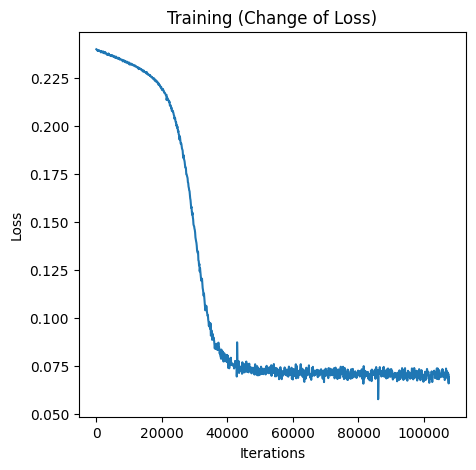

In [ ]:
#Plotting the Training Loss across Iterations
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.plot(iterations, train_loss, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training (Change of Loss)')

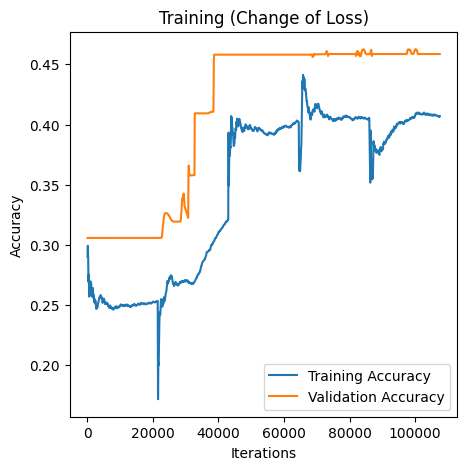

In [ ]:
#Plotting the Training/Validation Accuracy across Iterations
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.plot(iterations, train_acc, label='Training Accuracy')
plt.plot(iterations, val_acc, label='Validation Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Training (Change of Loss)')
plt.legend(loc='best')

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you
chose the next set of hyperparameters to try.

### Version 2

Compared with Version 1, I feel that because the learning rate is too small and the number of epochs are only 5, the model could attain a better convergence on increasing the learning rate to 0.001 and training it for a longer period of time in 10 epochs, with same batch size.

The model achieved 74% training accuracy and 60% validation accuracy, better than the first version, indicating that our reasoning was correct.

In [ ]:
model_2 = AutoEncoder()

In [ ]:
train_loss_2, train_acc_2, val_acc_2, iterations_2 = train(model_2, train_loader, val_loader, num_epochs = 10, learning_rate=0.001)

Epoch 1 Training Loss 0.06859058141708374 Training Accuracy 0.3776857966700772 Validation Accuracy 0.4587222342811663
Epoch 2 Training Loss 0.07184717059135437 Training Accuracy 0.5269199764363005 Validation Accuracy 0.571919542724839
Epoch 3 Training Loss 0.05632657930254936 Training Accuracy 0.5760626918426193 Validation Accuracy 0.5828811229288764
Epoch 4 Training Loss 0.021215545013546944 Training Accuracy 0.6201206089356028 Validation Accuracy 0.5881991172852905
Epoch 5 Training Loss 0.03170807287096977 Training Accuracy 0.6603261712088798 Validation Accuracy 0.5947109471094711
Epoch 6 Training Loss 0.024839408695697784 Training Accuracy 0.6874941865872942 Validation Accuracy 0.6012227769336517
Epoch 7 Training Loss 0.032867319881916046 Training Accuracy 0.7088952965615601 Validation Accuracy 0.596519788727299
Epoch 8 Training Loss 0.02057518996298313 Training Accuracy 0.7234753356276935 Validation Accuracy 0.6049128138340207
Epoch 9 Training Loss 0.016274310648441315 Training Acc

### Version 3

At the end of Version 2, there was a clear sign that the model was about to overfit the data given slight increase in loss and training loss. So, I decided for version to slightly reduce the learning rate to 0.0007 while increasing the number of epochs to 15. This would make the model train slower and for a longer period while capturing more detailed patterns.

Even this model, achieved a training accuracy of 74% and validation accuracy of 59%, indicating that more epochs and a lower learning rate did not impact the model's training significantly.

In [ ]:
model_3 = AutoEncoder()

In [ ]:
train_loss_3, train_acc_3, val_acc_3, iterations_3 = train(model_3, train_loader, val_loader, num_epochs = 15, learning_rate=0.0007)

Epoch 1 Training Loss 0.07025384902954102 Training Accuracy 0.35416085325396085 Validation Accuracy 0.45861370378409666
Epoch 2 Training Loss 0.07811783254146576 Training Accuracy 0.48131181595510497 Validation Accuracy 0.5516243397728094
Epoch 3 Training Loss 0.061859868466854095 Training Accuracy 0.5440501658760425 Validation Accuracy 0.5701468779393676
Epoch 4 Training Loss 0.03727606683969498 Training Accuracy 0.5989210306018045 Validation Accuracy 0.5868243976557412
Epoch 5 Training Loss 0.03190317004919052 Training Accuracy 0.6491799212476359 Validation Accuracy 0.5968815570508647
Epoch 6 Training Loss 0.04415074735879898 Training Accuracy 0.6700384460360277 Validation Accuracy 0.5919976846827292
Epoch 7 Training Loss 0.03214440494775772 Training Accuracy 0.6817970421356153 Validation Accuracy 0.5871138123145937
Epoch 8 Training Loss 0.030097709968686104 Training Accuracy 0.6825024028772517 Validation Accuracy 0.5925765140004341
Epoch 9 Training Loss 0.021938234567642212 Training

### Version 4

As training is taking a lot of time, for this model, I decided to increase the batch size from 100 to 150 to speed up training, while keeping the learning rate at 0.001, a low learning rate to prevent the loss from fluctuating too much. Also increased the number of epochs to 20 so that it trains longer on the larger batches to get better patterns.

The model achieved a training accuracy of 73% and a validation accuracy of 60%. Compared with version 2, there wasn't significant difference. However, the end evaluation metrics suggest that the model could have been trained for a longer period of time.

In [ ]:
model_4 = AutoEncoder()

In [ ]:
train_loader_4 = DataLoader(train_dataset, batch_size = 150, shuffle = True)
val_loader_4 = DataLoader(val_dataset, batch_size = 150, shuffle = True)
test_loader_4 = DataLoader(test_dataset, batch_size = 150, shuffle = True)

In [ ]:
train_loss_4, train_acc_4, val_acc_4, iterations_4 = train(model_4, train_loader_4, val_loader_4, num_epochs = 20, learning_rate=0.001)

Epoch 1 Training Loss 0.06849571317434311 Training Accuracy 0.3550599944191238 Validation Accuracy 0.4622675638521091
Epoch 2 Training Loss 0.056287121027708054 Training Accuracy 0.5100610795894955 Validation Accuracy 0.5570870414586498
Epoch 3 Training Loss 0.054004523903131485 Training Accuracy 0.547871515827985 Validation Accuracy 0.5722813110484046
Epoch 4 Training Loss 0.04832325503230095 Training Accuracy 0.5700089914116516 Validation Accuracy 0.5871499891469503
Epoch 5 Training Loss 0.039186906069517136 Training Accuracy 0.6090906272284748 Validation Accuracy 0.5970262643802908
Epoch 6 Training Loss 0.04184027016162872 Training Accuracy 0.6460174247356835 Validation Accuracy 0.5989436364951884
Epoch 7 Training Loss 0.0358734130859375 Training Accuracy 0.6653567110036276 Validation Accuracy 0.6009695391071558
Epoch 8 Training Loss 0.035406406968832016 Training Accuracy 0.6777974141940285 Validation Accuracy 0.6057448809782215
Epoch 9 Training Loss 0.03460678830742836 Training Acc

### Version 5

For version 5, I have introducted dropouts to prevent any overfitting. Also increased the number of epochs to 30 as version 4 could have clearly been trained for longer. The same parameters from version 4 have been used with dropout layers (10% probability) to prevent overfitting and more epochs.

It is clear that this is the model architecture's peak performance as despite more training, training accuracy is at 72% and validation accuracy is at 60%.


In [ ]:
class AutoEncoder2(nn.Module):
    def __init__(self):
        super(AutoEncoder2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 48),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(48, 24),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(24, 11)
        )
        self.decoder = nn.Sequential(
            nn.Linear(11, 24),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(24, 48),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(48, 57),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
model_5 = AutoEncoder2()

In [ ]:
train_loss_5, train_acc_5, val_acc_5, iterations_5 = train(model_5, train_loader_4, val_loader_4, num_epochs = 30, learning_rate=0.001)

Epoch 1 Training Loss 0.07027284055948257 Training Accuracy 0.3546724335720708 Validation Accuracy 0.45662397800448595
Epoch 2 Training Loss 0.06116538122296333 Training Accuracy 0.4826295228350851 Validation Accuracy 0.5467042905723175
Epoch 3 Training Loss 0.04482561722397804 Training Accuracy 0.5418720739156048 Validation Accuracy 0.5713768902394907
Epoch 4 Training Loss 0.048113249242305756 Training Accuracy 0.5534291383747248 Validation Accuracy 0.5746689819839375
Epoch 5 Training Loss 0.04456371068954468 Training Accuracy 0.5776671937494187 Validation Accuracy 0.5850879097026265
Epoch 6 Training Loss 0.042122624814510345 Training Accuracy 0.6032152047871516 Validation Accuracy 0.5889226539324217
Epoch 7 Training Loss 0.04203690215945244 Training Accuracy 0.6198028090410195 Validation Accuracy 0.5953621300918892
Epoch 8 Training Loss 0.04282543808221817 Training Accuracy 0.6218878863981645 Validation Accuracy 0.5968092033861515
Epoch 9 Training Loss 0.040918365120887756 Training A

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

model_4 has the best validation accuracy and thus, has been chosen as the best model. It achieves a test accuracy of 60.85%.

In [ ]:
get_accuracy(model_4, test_loader_4)

0.6085918854415274

### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set.

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [ ]:
train_data #Our Training Data in a numpy array

array([[0.23287672, 0.6       , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.63013697, 0.6       , 0.10566106, ..., 0.        , 0.        ,
        1.        ],
       [0.47945204, 0.53333336, 0.        , ..., 1.        , 1.        ,
        0.        ],
       ...,
       [0.15068494, 0.6       , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.72602737, 0.33333334, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.5753425 , 0.53333336, 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [ ]:
#Collecting the most occuring category in each feature in train_data
from collections import Counter
predictions = {}
for feature, start in cat_index.items():
  stop = start + len(cat_values[feature])
  features = []
  for row in train_data:
    features.append(get_categorical_value(row[start:stop], feature))
  counter = Counter(features)
  most_common, _ = counter.most_common(1)[0]
  predictions[feature] = most_common

In [ ]:
predictions #Contains predictions (most common occurrence of a feature) of our baseline

{'work': 'Private',
 'marriage': 'Divorced',
 'occupation': 'Adm-clerical',
 'edu': '10th',
 'relationship': 'Husband',
 'sex': 'Female'}

In [ ]:
def baseline_model(input): #Input is the column for prediction
  """Input- Column for prediction
     Output- Prediction
  """
  return predictions[input]

### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

Baseline has a accuracy of 43.1% compared with the about 60% for model_4. The testing procedure is almost same as the get_accuracy function in the training part earlier.

In [ ]:
test_data #Test Data in numpy array

array([[0.08219178, 0.26666668, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.09589041, 0.46666667, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.60273975, 0.6       , 0.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.1369863 , 0.6       , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.24657534, 0.53333336, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.16438356, 0.8       , 0.        , ..., 0.        , 0.        ,
        1.        ]], dtype=float32)

In [ ]:
#Testing on test_data (Test Data in numpy array)
total = 0
acc = 0
for col in catcols:
  for sample in test_data:
    corr = get_feature(sample, col)
    pred = baseline_model(col)
    if pred == corr:
      acc += 1
    total += 1
print(f'Test Data Accuracy {(float)((acc)/total)}')

Test Data Accuracy 0.4312576842409778


### Part (d) [1 pt]

Look at the first item in your test data.
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

The first item in the test dataset is about a 12th graduate male, never-married person who's occupation is private farm-fishing. It is more likely for a human to guess that the person did not complete higher post secondary education due to the person's occupation.

In [ ]:
test_data[1] #First item in data

array([0.08219178, 0.26666668, 0.        , 0.        , 0.29591838,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       1.        , 0.        ], dtype=float32)

In [ ]:
print(get_feature(test_data[1], 'edu'))
print(get_feature(test_data[1], 'work'))
print(get_feature(test_data[1], 'marriage'))
print(get_feature(test_data[1], 'occupation'))
print(get_feature(test_data[1], 'relationship'))
print(get_feature(test_data[1], 'sex'))

12th
Private
Never-married
Farming-fishing
Own-child
Male


### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?

Model Version 4 predicts 11th which is very close to 12th (actual value)

In [ ]:
data = test_data[1]
data[cat_index['edu']:cat_index['edu']+len(cat_values['edu'])] = 0
pred = model_4(torch.Tensor(data))
get_feature(pred, 'edu')

'11th'

### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

Baseline Model predicts 10th which is worse than the model's prediction compared to 12th.

In [ ]:
baseline_model('edu')

'10th'